In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%ls '/gdrive/My Drive/External Projects/chest/'
BASE_PATH = '/gdrive/My Drive/External Projects/chest/'

A2_TL_Resnet.ipynb  weights/


In [ ]:
import zipfile as zf  
files = zf.ZipFile(BASE_PATH+"archive.zip", 'r')
files.extractall()
files.close()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch  
base_dir = "chest_xray/chest_xray" 

In [ ]:
from torchvision import transforms
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  
        transforms.ToTensor(),
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
    ]),
}

In [ ]:
from torchvision.datasets import ImageFolder

train_ds = ImageFolder(root=os.path.join(base_dir,"train"), transform=image_transforms['train'])
test_ds = ImageFolder(root=os.path.join(base_dir,"test"), transform=image_transforms['test'])
print(len(train_ds), len(test_ds))
class_names = train_ds.classes
print(class_names)

5216 624
['NORMAL', 'PNEUMONIA']


In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, pin_memory=True)

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")

In [ ]:
images, labels = iter(train_dl).next()
images.shape

torch.Size([32, 3, 224, 224])

In [ ]:
import torchvision.models as models
net = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
print(net.layer4[1])

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
import torch.nn as nn

num_ftrs = net.fc.in_features

net.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512,2),
)

net = net.to(device)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
ct = 0
for child in net.children():
  ct += 1
  if ct < 8:
      for param in child.parameters():
          param.requires_grad = False

In [ ]:
# for param in net.parameters():
#     param.requires_grad = False

In [ ]:
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
weights = [1.0, .5]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(net.parameters(), lr=0.008, momentum=0.9)

if torch.cuda.is_available():
    net = net.cuda()
    criterion = criterion.cuda()
EPOCHS = 50
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def evaluate(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    return precision, recall, accuracy

all_train_metrics = []
all_test_metrics = []
best_acc = 0
for epoch in range(EPOCHS): 
    net.train()
    true_labels = []
    pred_labels = []
    for i, (inputs, labels) in enumerate(train_dl, 0):
        true_labels += [t.cpu().numpy() for t in labels]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        pred_labels += [p.cpu().numpy() for p in predicted]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()
 
    precision, recall, accuracy = evaluate(true_labels, pred_labels)
    all_train_metrics.append({"pres":precision, "recall":recall, "acc": accuracy})
    if (epoch % 10 == 0):
      print("Train Epoch: {} Pres: {:.2f} Recall: {:.2f} Acc: {:.2f}".format(epoch, precision, recall, accuracy))

    net.eval()
    true_labels = []
    pred_labels = []
    for i, (inputs, labels) in enumerate(test_dl, 0):
        true_labels += [t.cpu().numpy() for t in labels]
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        pred_labels += [p.cpu().numpy() for p in predicted]

    precision, recall, accuracy = evaluate(true_labels, pred_labels)
    all_test_metrics.append({"pres":precision, "recall":recall, "acc": accuracy})
    if (epoch % 10 == 0):
      print("Test  Epoch: {} Pres: {:.2f} Recall: {:.2f} Acc: {:.2f}".format(epoch, precision, recall, accuracy))

    if accuracy > best_acc:
      print("Saved Model")
      torch.save(net.state_dict(),"/gdrive/My Drive/External Projects/chest/weights/model_1.pt")
      best_acc = accuracy
print('Finished Training')

Train Epoch: 0 Pres: 0.97 Recall: 0.94 Acc: 0.93
Test  Epoch: 0 Pres: 0.86 Recall: 0.99 Acc: 0.89
Saved Model
Train Epoch: 1 Pres: 0.98 Recall: 0.95 Acc: 0.95
Test  Epoch: 1 Pres: 0.78 Recall: 0.99 Acc: 0.82
Train Epoch: 2 Pres: 0.99 Recall: 0.97 Acc: 0.97
Test  Epoch: 2 Pres: 0.84 Recall: 0.99 Acc: 0.88
Train Epoch: 3 Pres: 0.99 Recall: 0.97 Acc: 0.97
Test  Epoch: 3 Pres: 0.88 Recall: 0.99 Acc: 0.91
Saved Model
Train Epoch: 4 Pres: 0.99 Recall: 0.97 Acc: 0.97
Test  Epoch: 4 Pres: 0.86 Recall: 0.99 Acc: 0.90
Train Epoch: 5 Pres: 0.99 Recall: 0.98 Acc: 0.98
Test  Epoch: 5 Pres: 0.83 Recall: 0.99 Acc: 0.87
Train Epoch: 6 Pres: 0.99 Recall: 0.98 Acc: 0.98
Test  Epoch: 6 Pres: 0.90 Recall: 0.98 Acc: 0.92
Saved Model
Train Epoch: 7 Pres: 0.99 Recall: 0.98 Acc: 0.98
Test  Epoch: 7 Pres: 0.88 Recall: 0.99 Acc: 0.91
Train Epoch: 8 Pres: 0.99 Recall: 0.98 Acc: 0.98
Test  Epoch: 8 Pres: 0.84 Recall: 0.99 Acc: 0.88
Train Epoch: 9 Pres: 0.99 Recall: 0.98 Acc: 0.98
Test  Epoch: 9 Pres: 0.86 Recall:

In [ ]:
# torch.save(net.state_dict(),"/gdrive/My Drive/External Projects/chest/weights/model_1.pt")
import pickle
pickle.dump(all_train_metrics,open("/gdrive/My Drive/External Projects/chest/weights/train_metrics_1.pkl",'wb'))
pickle.dump(all_test_metrics,open("/gdrive/My Drive/External Projects/chest/weights/test_metrics_1.pkl",'wb'))

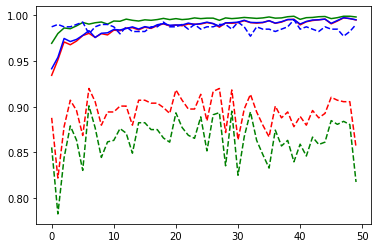

In [ ]:
import matplotlib.pyplot as plt

plt.plot([metrics["acc"] for metrics in all_train_metrics], 'r-')
plt.plot([metrics["pres"] for metrics in all_train_metrics], 'g-')
plt.plot([metrics["recall"] for metrics in all_train_metrics], 'b-')
plt.plot([metrics["acc"] for metrics in all_test_metrics], 'r--')
plt.plot([metrics["pres"] for metrics in all_test_metrics], 'g--')
plt.plot([metrics["recall"] for metrics in all_test_metrics], 'b--')
plt.show()